In [1]:
import numpy as np
import pandas as pd
import datetime
import os

from DP_LSTM import *
from keras.models import load_model
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from Plot_Self_Correlation import plot_auto_corr

from matplotlib import pyplot as plt

A:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def walkfiles(rootdir): # 返回file路径的list
    flist = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    pathContainer = []
    filenameContainer = []
    for i in range(0,len(flist)):
        path = os.path.join(rootdir,flist[i])
        if os.path.isfile(path):
            pathContainer.append(path)
            filenameContainer.append(flist[i])
    return pathContainer,filenameContainer

rootdir = r'D:\WORK__wells\GraduateProgram\Data\DailyData'
pathContainer,filenameContainer = walkfiles(rootdir)

In [3]:
#首先对一种货币进行短期预测实验
# 第i个文件
'''
['D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\AUDUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\EURUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\GBPUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDCAD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDCHF.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDCNY.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDJPY.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\外汇数据.xlsx']
'''
i = 1
ExgRate_pd = pd.read_csv(pathContainer[i])
ExgRate_pd['DateTime'] = pd.to_datetime(ExgRate_pd.Date)
ExgRate_pd['ExgRate'] = ExgRate_pd.close
ExgRate_pd.drop(['Date','open','high','low','close'],axis=1,inplace=True)
ExgRate_pd = ExgRate_pd.loc[ExgRate_pd.DateTime>'2009']
ExgRate_pd.index = [i for i in range(ExgRate_pd.shape[0])]

In [4]:
preTrained_pd = ExgRate_pd.loc[ExgRate_pd.DateTime < '2015']
preTrained_pd.index = [i for i in range(preTrained_pd.shape[0])]
data_pd = ExgRate_pd.loc[ExgRate_pd.DateTime > '2015']
data_pd.index = [i for i in range(data_pd.shape[0])]

In [5]:
'''数据处理模块'''
#对实验数据进行归一化处理
def GetTimeScale(data_pd, Time_scale):#根据给定的时间宽度构造数据
    result_dic = {'DateTime':[],'ExgRate':[]}
    for i in range(data_pd.shape[0]):
        if (i+1)%Time_scale == 0:
            new_grid_pd = data_pd.iloc[i,:]
            result_dic['DateTime'].append(new_grid_pd.DateTime)
            result_dic['ExgRate'].append(new_grid_pd.ExgRate)
    result_pd = pd.DataFrame(result_dic)
    return result_pd

# 计算 log收益率 *100
def GetProfit(TimeScale_pd):
    result_dic = {'DateTime':[],'ExgRate':[]}
    for i in range(1,TimeScale_pd.shape[0]):
        local_pd = TimeScale_pd.iloc[i,:]
        pre_pd = TimeScale_pd.iloc[i-1,:]
        result_dic['DateTime'].append(local_pd.DateTime)
        result_dic['ExgRate'].append(math.pow(100*(math.log(local_pd.ExgRate) - math.log(pre_pd.ExgRate)),
                                             2))
    result_pd = pd.DataFrame(result_dic)
    return result_pd

def Raw_Data_Normalized(Raw_df): # 标准化数据
    Raw_pd = Raw_df.copy()
    Raw_pd_empty = Raw_pd.loc[Raw_pd.ExgRate.isna()]
    Raw_pd_Nonempty = Raw_pd.drop(Raw_pd_empty.index,axis=0)
    MMScaler = MinMaxScaler(feature_range=(1,2))
    MMScaled_Data = MMScaler.fit_transform(np.reshape(Raw_pd_Nonempty['ExgRate'].get_values(),(Raw_pd_Nonempty.ExgRate.shape[0],1)))
    Raw_pd_Nonempty['ExgRate'] = MMScaled_Data
    Raw_pd = pd.concat([Raw_pd_Nonempty, Raw_pd_empty])
    return Raw_pd,MMScaler

def GetTimeSeriesData(Normalized_pd, TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    for index in range(len(Normalized_pd) - sequence_length):
        result.append(Normalized_pd.ExgRate[index: index + sequence_length])
    result = np.array(result)
    return result

In [6]:
'''
迁移学习主要模块：基模型的预训练、FineTune
'''
def PrePareLSTM(ExgRate_pd,params):
    print(r'预训练模型')
    Base_pd = ExgRate_pd.copy()
    Base_pd,BaseMMScaler = Raw_Data_Normalized(Base_pd)
    TimeSeries = GetTimeSeriesData(Base_pd, params['TimeLag'])
    PretrainSeries_X = TimeSeries[:,:-1]
    PretrainSeries_Y = TimeSeries[:,-1]
    # 张量化
    PretrainSeries_X = np.reshape(PretrainSeries_X, (PretrainSeries_X.shape[0], 1,PretrainSeries_X.shape[1]))
    PretrainSeries_Y = np.reshape(PretrainSeries_Y, (PretrainSeries_Y.shape[0], 1,1))
    #预先训练基本模型
    pre_Model = build_LSTM_Model(inputDim = PretrainSeries_X.shape[2],lr=params['lr'],
                                 nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_pre_model = model_fit(pre_Model,PretrainSeries_X, PretrainSeries_Y, 
                                 validation_split=0.2, epochs=params['epochs'], 
                                 batch_size=params['batch_size'])
    print(r'预训练模型学习完毕！') 
    return Fitted_pre_model

def FineTune(Prepared_model, Train_X, Train_Y,params,numfrozenLayer):
    from keras.layers import Dense
    model_new = Prepared_model
    model_new.pop()
    for i in range(len(Prepared_model.layers)):  # 除最后一层外，权重全部导入
        model_new.layers[i].set_weights(Prepared_model.layers[i].get_weights())
        if i < numfrozenLayer:
            model_new.layers[i].trainable=False
    
#     model_new.add(Dense(5, activation='sigmoid', name='last2'))
    model_new.add(Dense(1,use_bias = True,activation='linear'))
#     saveFile = 'D:/CPQ/air/hour_tranfer_hour'
    #调整迁移预测数据准备
    # 标准化进行预测
    print('微调迁移学习模型')
    Prepared_model = model_fit(model_new, Train_X, 
                                   Train_Y,epochs=params['TransferEpochs'], 
                                   batch_size=params['TransferBatch_size'])
    return Prepared_model

In [7]:
'''
已知时间越长，LSTM预测的效果越差，那么接下来看是否迁移学习对预测效果有没有提升


'''
'''
输入：DataFrame， 参数params
输出： 与BP神经网络、支持向量回归和时间序列模型进行比较得到的各项指标与预测的值DateFrame
'''


def TransferLearning_frozenLayer(data_pd, PrepareModel,params):
    #定义存储结果的pd
    result_pd = pd.DataFrame(columns=['frozenlayer','RMSE','MAE','MAPE',
                                      'T-RMSE','T-MAE','T-MAPE'])
    line_pd = pd.DataFrame(columns=['frozenlayer','RMSE','MAE','MAPE',
                                    'T-RMSE','T-MAE','T-MAPE'])
    # 对数据进行预处理
    for numfrozenLayer in params['frozenlayer']:   
        print(r'冻结层数',numfrozenLayer)
        scaleddata_pd = GetTimeScale(data_pd, params['Timescale'])
    
        Raw_pd,MMScaler = Raw_Data_Normalized(scaleddata_pd)
        print(r'处理数据:',Raw_pd.shape)
        # 构造时间序列数据
        TimeSeries = GetTimeSeriesData(Raw_pd, params['TimeLag'])
        # 划分训练测试集
        TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
        print(r'训练数据:',TrainSeries.shape)
        TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
        print(r'验证数据:',TestSeries.shape)
        TrainSeries_X = TrainSeries[:,:-1]
        TrainSeries_Y = TrainSeries[:,-1]
        TestSeries_X = TestSeries[:,:-1]
        TestSeries_Y = TestSeries[:,-1]
        # 张量化
        Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
        Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
        Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
        Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
        
        print(r'迁移学习微调')
        Prepared_model = FineTune(PrepareModel, Train_X, Train_Y,params,numfrozenLayer)
        print(r'迁移学习LSTM预测')
        RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Prepared_model,Test_X,Test_Y,MMScaler)
        line_pd['frozenlayer'] = [numfrozenLayer]
        line_pd['T-RMSE'] = [RMSE]
        line_pd['T-MAE'] = [MAE]
        line_pd['T-MAPE'] = [MAPE]
        result_pd = pd.concat([result_pd, line_pd])
    result_pd.to_csv(r'D:\WORK__wells\GraduateProgram\Result\迁移预测结果.csv',index=None)
    result_pd.index = [i for i in range(result_pd.shape[0])]
    return result_pd

冻结层数 1
处理数据: (307, 2)
训练数据: (207, 11)
验证数据: (89, 11)
迁移学习微调
微调迁移学习模型
Train on 144 samples, validate on 63 samples
Epoch 1/200
144/144 [==============================] - 3s 23ms/step - loss: 0.7821 - mean_absolute_error: 0.8480 - mean_absolute_percentage_error: 63.8766 - val_loss: 0.1001 - val_mean_absolute_error: 0.2942 - val_mean_absolute_percentage_error: 21.9459
Epoch 2/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0529 - mean_absolute_error: 0.2036 - mean_absolute_percentage_error: 15.4983 - val_loss: 0.0337 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 13.6044
Epoch 3/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1124 - mean_absolute_percentage_error: 8.6485 - val_loss: 0.0304 - val_mean_absolute_error: 0.1397 - val_mean_absolute_percentage_error: 9.8594
Epoch 4/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0134 - mean_absolute_error: 0.0929 - mean_absolute_

144/144 [==============================] - 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 5.5524 - val_loss: 0.0134 - val_mean_absolute_error: 0.0966 - val_mean_absolute_percentage_error: 7.2262
Epoch 66/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 5.5520 - val_loss: 0.0134 - val_mean_absolute_error: 0.0966 - val_mean_absolute_percentage_error: 7.2241
Epoch 67/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 5.5517 - val_loss: 0.0134 - val_mean_absolute_error: 0.0966 - val_mean_absolute_percentage_error: 7.2221
Epoch 68/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 5.5513 - val_loss: 0.0134 - val_mean_absolute_error: 0.0965 - val_mean_absolute_percentage_error: 7.2201
Epoch

144/144 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 5.5301 - val_loss: 0.0130 - val_mean_absolute_error: 0.0951 - val_mean_absolute_percentage_error: 7.1070
Epoch 130/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 5.5298 - val_loss: 0.0130 - val_mean_absolute_error: 0.0951 - val_mean_absolute_percentage_error: 7.1053
Epoch 131/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 5.5294 - val_loss: 0.0130 - val_mean_absolute_error: 0.0950 - val_mean_absolute_percentage_error: 7.1036
Epoch 132/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 5.5291 - val_loss: 0.0130 - val_mean_absolute_error: 0.0950 - val_mean_absolute_percentage_error: 7.1019
Ep

144/144 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5083 - val_loss: 0.0126 - val_mean_absolute_error: 0.0938 - val_mean_absolute_percentage_error: 7.0051
Epoch 194/200
144/144 [==============================] - 0s 958us/step - loss: 0.0084 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5079 - val_loss: 0.0126 - val_mean_absolute_error: 0.0937 - val_mean_absolute_percentage_error: 7.0037
Epoch 195/200
144/144 [==============================] - 0s 986us/step - loss: 0.0084 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5076 - val_loss: 0.0126 - val_mean_absolute_error: 0.0937 - val_mean_absolute_percentage_error: 7.0022
Epoch 196/200
144/144 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5073 - val_loss: 0.0126 - val_mean_absolute_error: 0.0937 - val_mean_absolute_percentage_error: 7.000

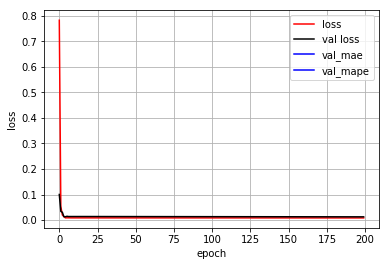

迁移学习LSTM预测


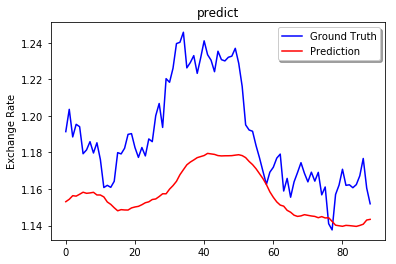

RMSE:0.036654009412676034  ,MAE:0.03179707622099458  ,MAPE:2.6432646248286376 
冻结层数 2
处理数据: (307, 2)
训练数据: (207, 11)
验证数据: (89, 11)
迁移学习微调
微调迁移学习模型
Train on 144 samples, validate on 63 samples
Epoch 1/200
144/144 [==============================] - 3s 21ms/step - loss: 0.9180 - mean_absolute_error: 0.9266 - mean_absolute_percentage_error: 69.8243 - val_loss: 0.1995 - val_mean_absolute_error: 0.4188 - val_mean_absolute_percentage_error: 31.3203
Epoch 2/200
144/144 [==============================] - 0s 813us/step - loss: 0.0472 - mean_absolute_error: 0.1787 - mean_absolute_percentage_error: 13.5408 - val_loss: 0.0544 - val_mean_absolute_error: 0.2030 - val_mean_absolute_percentage_error: 17.5307
Epoch 3/200
144/144 [==============================] - 0s 757us/step - loss: 0.0316 - mean_absolute_error: 0.1412 - mean_absolute_percentage_error: 11.2196 - val_loss: 0.0185 - val_mean_absolute_error: 0.1134 - val_mean_absolute_percentage_error: 8.6526
Epoch 4/200
144/144 [=======================

144/144 [==============================] - 0s 847us/step - loss: 0.0084 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 5.5474 - val_loss: 0.0167 - val_mean_absolute_error: 0.1076 - val_mean_absolute_percentage_error: 8.1204
Epoch 65/200
144/144 [==============================] - 0s 764us/step - loss: 0.0084 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 5.5470 - val_loss: 0.0167 - val_mean_absolute_error: 0.1075 - val_mean_absolute_percentage_error: 8.1115
Epoch 66/200
144/144 [==============================] - 0s 806us/step - loss: 0.0084 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 5.5465 - val_loss: 0.0166 - val_mean_absolute_error: 0.1074 - val_mean_absolute_percentage_error: 8.1027
Epoch 67/200
144/144 [==============================] - 0s 819us/step - loss: 0.0084 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 5.5461 - val_loss: 0.0166 - val_mean_absolute_error: 0.1073 - val_mean_absolute_percentage_error: 8.09

144/144 [==============================] - 0s 875us/step - loss: 0.0083 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 5.5245 - val_loss: 0.0149 - val_mean_absolute_error: 0.1014 - val_mean_absolute_percentage_error: 7.6112
Epoch 129/200
144/144 [==============================] - 0s 785us/step - loss: 0.0083 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 5.5243 - val_loss: 0.0149 - val_mean_absolute_error: 0.1013 - val_mean_absolute_percentage_error: 7.6045
Epoch 130/200
144/144 [==============================] - 0s 764us/step - loss: 0.0083 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 5.5240 - val_loss: 0.0149 - val_mean_absolute_error: 0.1012 - val_mean_absolute_percentage_error: 7.5982
Epoch 131/200
144/144 [==============================] - 0s 792us/step - loss: 0.0083 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 5.5237 - val_loss: 0.0149 - val_mean_absolute_error: 0.1011 - val_mean_absolute_percentage_error: 7

144/144 [==============================] - 0s 951us/step - loss: 0.0083 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5091 - val_loss: 0.0138 - val_mean_absolute_error: 0.0977 - val_mean_absolute_percentage_error: 7.3151
Epoch 193/200
144/144 [==============================] - 0s 882us/step - loss: 0.0083 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5089 - val_loss: 0.0138 - val_mean_absolute_error: 0.0976 - val_mean_absolute_percentage_error: 7.3116
Epoch 194/200
144/144 [==============================] - 0s 854us/step - loss: 0.0083 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5087 - val_loss: 0.0137 - val_mean_absolute_error: 0.0976 - val_mean_absolute_percentage_error: 7.3082
Epoch 195/200
144/144 [==============================] - 0s 875us/step - loss: 0.0083 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 5.5085 - val_loss: 0.0137 - val_mean_absolute_error: 0.0975 - val_mean_absolute_percentage_error: 7

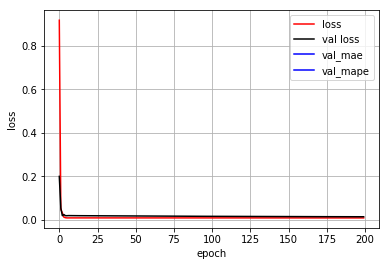

迁移学习LSTM预测


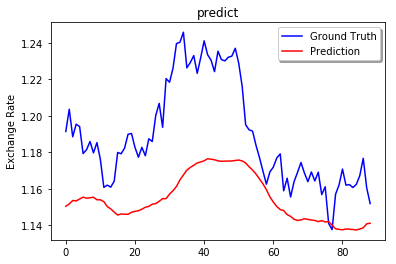

RMSE:0.039041544834159794  ,MAE:0.03435040392072013  ,MAPE:2.857312223816842 
冻结层数 3
处理数据: (307, 2)
训练数据: (207, 11)
验证数据: (89, 11)
迁移学习微调
微调迁移学习模型
Train on 144 samples, validate on 63 samples
Epoch 1/200
144/144 [==============================] - 3s 20ms/step - loss: 0.5560 - mean_absolute_error: 0.7014 - mean_absolute_percentage_error: 52.7971 - val_loss: 0.0669 - val_mean_absolute_error: 0.2183 - val_mean_absolute_percentage_error: 15.6055
Epoch 2/200
144/144 [==============================] - 0s 771us/step - loss: 0.0244 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 9.9820 - val_loss: 0.0382 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 14.4068
Epoch 3/200
144/144 [==============================] - 0s 681us/step - loss: 0.0227 - mean_absolute_error: 0.1162 - mean_absolute_percentage_error: 9.2643 - val_loss: 0.0166 - val_mean_absolute_error: 0.1075 - val_mean_absolute_percentage_error: 8.1613
Epoch 4/200
144/144 [==========================

144/144 [==============================] - 0s 701us/step - loss: 0.0083 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 5.5181 - val_loss: 0.0155 - val_mean_absolute_error: 0.1034 - val_mean_absolute_percentage_error: 7.7719
Epoch 65/200
144/144 [==============================] - 0s 688us/step - loss: 0.0083 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 5.5178 - val_loss: 0.0155 - val_mean_absolute_error: 0.1033 - val_mean_absolute_percentage_error: 7.7657
Epoch 66/200
144/144 [==============================] - 0s 667us/step - loss: 0.0083 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 5.5176 - val_loss: 0.0154 - val_mean_absolute_error: 0.1032 - val_mean_absolute_percentage_error: 7.7595
Epoch 67/200
144/144 [==============================] - 0s 674us/step - loss: 0.0083 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 5.5174 - val_loss: 0.0154 - val_mean_absolute_error: 0.1032 - val_mean_absolute_percentage_error: 7.75

144/144 [==============================] - 0s 674us/step - loss: 0.0083 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 5.5042 - val_loss: 0.0143 - val_mean_absolute_error: 0.0995 - val_mean_absolute_percentage_error: 7.4530
Epoch 129/200
144/144 [==============================] - 0s 688us/step - loss: 0.0083 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 5.5040 - val_loss: 0.0143 - val_mean_absolute_error: 0.0994 - val_mean_absolute_percentage_error: 7.4490
Epoch 130/200
144/144 [==============================] - 0s 694us/step - loss: 0.0083 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 5.5038 - val_loss: 0.0143 - val_mean_absolute_error: 0.0994 - val_mean_absolute_percentage_error: 7.4450
Epoch 131/200
144/144 [==============================] - 0s 674us/step - loss: 0.0083 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 5.5036 - val_loss: 0.0143 - val_mean_absolute_error: 0.0993 - val_mean_absolute_percentage_error: 7

Epoch 160/200
144/144 [==============================] - 0s 701us/step - loss: 0.0083 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 5.4983 - val_loss: 0.0139 - val_mean_absolute_error: 0.0981 - val_mean_absolute_percentage_error: 7.3417
Epoch 161/200
144/144 [==============================] - 0s 701us/step - loss: 0.0083 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 5.4981 - val_loss: 0.0139 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 7.3386
Epoch 162/200
144/144 [==============================] - 0s 701us/step - loss: 0.0083 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 5.4979 - val_loss: 0.0139 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 7.3355
Epoch 163/200
144/144 [==============================] - 0s 646us/step - loss: 0.0083 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 5.4977 - val_loss: 0.0139 - val_mean_absolute_error: 0.0980 - val_mean_absolute_perce

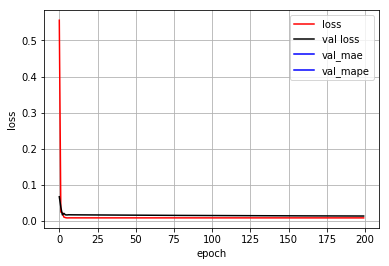

迁移学习LSTM预测


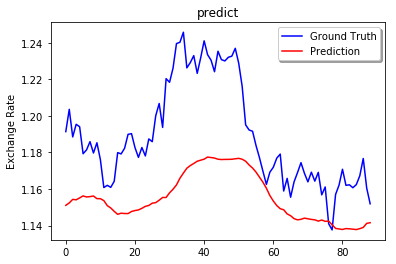

RMSE:0.03834646544654664  ,MAE:0.03364986986095985  ,MAPE:2.798821632550923 
冻结层数 4
处理数据: (307, 2)
训练数据: (207, 11)
验证数据: (89, 11)
迁移学习微调
微调迁移学习模型
Train on 144 samples, validate on 63 samples
Epoch 1/200
144/144 [==============================] - 2s 17ms/step - loss: 2.1337 - mean_absolute_error: 1.4385 - mean_absolute_percentage_error: 108.5931 - val_loss: 0.8866 - val_mean_absolute_error: 0.9234 - val_mean_absolute_percentage_error: 71.0242
Epoch 2/200
144/144 [==============================] - 0s 632us/step - loss: 0.3928 - mean_absolute_error: 0.5904 - mean_absolute_percentage_error: 44.3990 - val_loss: 0.0849 - val_mean_absolute_error: 0.2611 - val_mean_absolute_percentage_error: 19.1349
Epoch 3/200
144/144 [==============================] - 0s 708us/step - loss: 0.0203 - mean_absolute_error: 0.1122 - mean_absolute_percentage_error: 8.3576 - val_loss: 0.0120 - val_mean_absolute_error: 0.0920 - val_mean_absolute_percentage_error: 7.3747
Epoch 4/200
144/144 [=========================

144/144 [==============================] - 0s 646us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4596 - val_loss: 0.0138 - val_mean_absolute_error: 0.0976 - val_mean_absolute_percentage_error: 7.2660
Epoch 65/200
144/144 [==============================] - 0s 604us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4597 - val_loss: 0.0138 - val_mean_absolute_error: 0.0976 - val_mean_absolute_percentage_error: 7.2650
Epoch 66/200
144/144 [==============================] - 0s 681us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4598 - val_loss: 0.0138 - val_mean_absolute_error: 0.0976 - val_mean_absolute_percentage_error: 7.2641
Epoch 67/200
144/144 [==============================] - 0s 708us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4599 - val_loss: 0.0138 - val_mean_absolute_error: 0.0976 - val_mean_absolute_percentage_error: 7.26

Epoch 96/200
144/144 [==============================] - 0s 583us/step - loss: 0.0082 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 5.4625 - val_loss: 0.0137 - val_mean_absolute_error: 0.0972 - val_mean_absolute_percentage_error: 7.2350
Epoch 97/200
144/144 [==============================] - 0s 625us/step - loss: 0.0082 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 5.4626 - val_loss: 0.0137 - val_mean_absolute_error: 0.0972 - val_mean_absolute_percentage_error: 7.2340
Epoch 98/200
144/144 [==============================] - 0s 632us/step - loss: 0.0082 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 5.4626 - val_loss: 0.0137 - val_mean_absolute_error: 0.0972 - val_mean_absolute_percentage_error: 7.2330
Epoch 99/200
144/144 [==============================] - 0s 715us/step - loss: 0.0082 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 5.4627 - val_loss: 0.0137 - val_mean_absolute_error: 0.0971 - val_mean_absolute_percentag

144/144 [==============================] - 0s 549us/step - loss: 0.0082 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4674 - val_loss: 0.0134 - val_mean_absolute_error: 0.0963 - val_mean_absolute_percentage_error: 7.1704
Epoch 161/200
144/144 [==============================] - 0s 563us/step - loss: 0.0082 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4675 - val_loss: 0.0134 - val_mean_absolute_error: 0.0963 - val_mean_absolute_percentage_error: 7.1693
Epoch 162/200
144/144 [==============================] - 0s 444us/step - loss: 0.0082 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4675 - val_loss: 0.0134 - val_mean_absolute_error: 0.0963 - val_mean_absolute_percentage_error: 7.1683
Epoch 163/200
144/144 [==============================] - 0s 549us/step - loss: 0.0082 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4676 - val_loss: 0.0134 - val_mean_absolute_error: 0.0963 - val_mean_absolute_percentage_error: 7

Epoch 192/200
144/144 [==============================] - 0s 583us/step - loss: 0.0083 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4691 - val_loss: 0.0133 - val_mean_absolute_error: 0.0959 - val_mean_absolute_percentage_error: 7.1381
Epoch 193/200
144/144 [==============================] - 0s 521us/step - loss: 0.0083 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4692 - val_loss: 0.0133 - val_mean_absolute_error: 0.0959 - val_mean_absolute_percentage_error: 7.1371
Epoch 194/200
144/144 [==============================] - 0s 458us/step - loss: 0.0083 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4692 - val_loss: 0.0133 - val_mean_absolute_error: 0.0959 - val_mean_absolute_percentage_error: 7.1361
Epoch 195/200
144/144 [==============================] - 0s 549us/step - loss: 0.0083 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 5.4692 - val_loss: 0.0133 - val_mean_absolute_error: 0.0958 - val_mean_absolute_perce

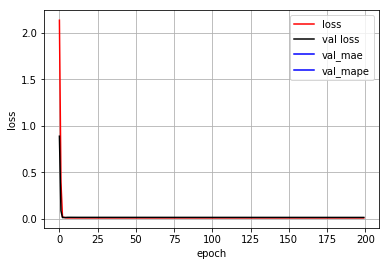

迁移学习LSTM预测


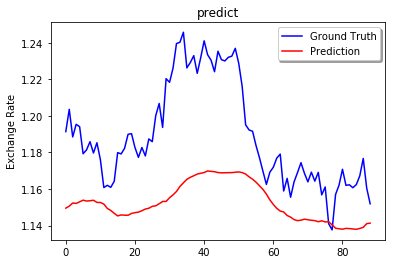

RMSE:0.041485014571526625  ,MAE:0.03636187182222859  ,MAPE:3.0228150358270462 
冻结层数 5
处理数据: (307, 2)
训练数据: (207, 11)
验证数据: (89, 11)
迁移学习微调
微调迁移学习模型
Train on 144 samples, validate on 63 samples
Epoch 1/200
144/144 [==============================] - 2s 11ms/step - loss: 1.3596 - mean_absolute_error: 1.1608 - mean_absolute_percentage_error: 87.3897 - val_loss: 1.0803 - val_mean_absolute_error: 1.0197 - val_mean_absolute_percentage_error: 78.4567
Epoch 2/200
144/144 [==============================] - 0s 347us/step - loss: 0.9148 - mean_absolute_error: 0.9506 - mean_absolute_percentage_error: 71.4880 - val_loss: 0.7294 - val_mean_absolute_error: 0.8338 - val_mean_absolute_percentage_error: 63.9045
Epoch 3/200
144/144 [==============================] - 0s 368us/step - loss: 0.6120 - mean_absolute_error: 0.7759 - mean_absolute_percentage_error: 58.2585 - val_loss: 0.5067 - val_mean_absolute_error: 0.6908 - val_mean_absolute_percentage_error: 52.7016
Epoch 4/200
144/144 [======================

144/144 [==============================] - 0s 424us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4529 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5180
Epoch 65/200
144/144 [==============================] - 0s 424us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4529 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5179
Epoch 66/200
144/144 [==============================] - 0s 451us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4529 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5179
Epoch 67/200
144/144 [==============================] - 0s 514us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4529 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.51

Epoch 96/200
144/144 [==============================] - 0s 368us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4538 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5166
Epoch 97/200
144/144 [==============================] - 0s 431us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4539 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5165
Epoch 98/200
144/144 [==============================] - 0s 431us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4539 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5165
Epoch 99/200
144/144 [==============================] - 0s 528us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4539 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentag

144/144 [==============================] - 0s 396us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4560 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5134
Epoch 161/200
144/144 [==============================] - 0s 444us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4561 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5134
Epoch 162/200
144/144 [==============================] - 0s 438us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4561 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7.5133
Epoch 163/200
144/144 [==============================] - 0s 438us/step - loss: 0.0081 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4561 - val_loss: 0.0147 - val_mean_absolute_error: 0.1007 - val_mean_absolute_percentage_error: 7

Epoch 192/200
144/144 [==============================] - 0s 389us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4571 - val_loss: 0.0147 - val_mean_absolute_error: 0.1006 - val_mean_absolute_percentage_error: 7.5117
Epoch 193/200
144/144 [==============================] - 0s 444us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4571 - val_loss: 0.0147 - val_mean_absolute_error: 0.1006 - val_mean_absolute_percentage_error: 7.5117
Epoch 194/200
144/144 [==============================] - 0s 458us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4571 - val_loss: 0.0147 - val_mean_absolute_error: 0.1006 - val_mean_absolute_percentage_error: 7.5116
Epoch 195/200
144/144 [==============================] - 0s 458us/step - loss: 0.0082 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 5.4571 - val_loss: 0.0147 - val_mean_absolute_error: 0.1006 - val_mean_absolute_perce

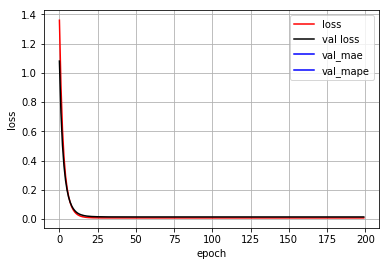

迁移学习LSTM预测


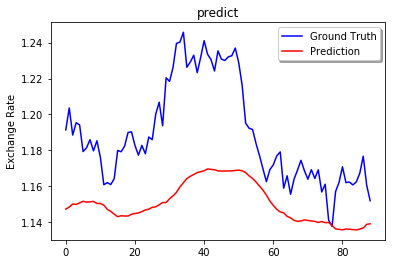

RMSE:0.04292271279270594  ,MAE:0.03814270116613152  ,MAPE:3.1734674483638043 
冻结层数 6
处理数据: (307, 2)
训练数据: (207, 11)
验证数据: (89, 11)
迁移学习微调
微调迁移学习模型
Train on 144 samples, validate on 63 samples
Epoch 1/200
144/144 [==============================] - 2s 13ms/step - loss: 2.7646 - mean_absolute_error: 1.6586 - mean_absolute_percentage_error: 125.0637 - val_loss: 2.2926 - val_mean_absolute_error: 1.4955 - val_mean_absolute_percentage_error: 115.8029
Epoch 2/200
144/144 [==============================] - 0s 375us/step - loss: 2.1049 - mean_absolute_error: 1.4465 - mean_absolute_percentage_error: 109.0187 - val_loss: 1.7533 - val_mean_absolute_error: 1.3058 - val_mean_absolute_percentage_error: 100.9503
Epoch 3/200
144/144 [==============================] - 0s 340us/step - loss: 1.6134 - mean_absolute_error: 1.2658 - mean_absolute_percentage_error: 95.3350 - val_loss: 1.3758 - val_mean_absolute_error: 1.1547 - val_mean_absolute_percentage_error: 89.1247
Epoch 4/200
144/144 [===================

144/144 [==============================] - 0s 389us/step - loss: 0.0082 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4421 - val_loss: 0.0137 - val_mean_absolute_error: 0.0975 - val_mean_absolute_percentage_error: 7.2514
Epoch 65/200
144/144 [==============================] - 0s 382us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4416 - val_loss: 0.0137 - val_mean_absolute_error: 0.0975 - val_mean_absolute_percentage_error: 7.2491
Epoch 66/200
144/144 [==============================] - 0s 458us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4412 - val_loss: 0.0137 - val_mean_absolute_error: 0.0974 - val_mean_absolute_percentage_error: 7.2470
Epoch 67/200
144/144 [==============================] - 0s 438us/step - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 5.4408 - val_loss: 0.0137 - val_mean_absolute_error: 0.0974 - val_mean_absolute_percentage_error: 7.24

Epoch 96/200
144/144 [==============================] - 0s 396us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4387 - val_loss: 0.0135 - val_mean_absolute_error: 0.0971 - val_mean_absolute_percentage_error: 7.2317
Epoch 97/200
144/144 [==============================] - 0s 424us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4387 - val_loss: 0.0135 - val_mean_absolute_error: 0.0971 - val_mean_absolute_percentage_error: 7.2316
Epoch 98/200
144/144 [==============================] - 0s 493us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4387 - val_loss: 0.0135 - val_mean_absolute_error: 0.0970 - val_mean_absolute_percentage_error: 7.2316
Epoch 99/200
144/144 [==============================] - 0s 417us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4388 - val_loss: 0.0135 - val_mean_absolute_error: 0.0970 - val_mean_absolute_percentag

144/144 [==============================] - 0s 382us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4403 - val_loss: 0.0135 - val_mean_absolute_error: 0.0970 - val_mean_absolute_percentage_error: 7.2296
Epoch 161/200
144/144 [==============================] - 0s 424us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4404 - val_loss: 0.0135 - val_mean_absolute_error: 0.0970 - val_mean_absolute_percentage_error: 7.2295
Epoch 162/200
144/144 [==============================] - 0s 458us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4404 - val_loss: 0.0135 - val_mean_absolute_error: 0.0970 - val_mean_absolute_percentage_error: 7.2295
Epoch 163/200
144/144 [==============================] - 0s 444us/step - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 5.4404 - val_loss: 0.0135 - val_mean_absolute_error: 0.0970 - val_mean_absolute_percentage_error: 7

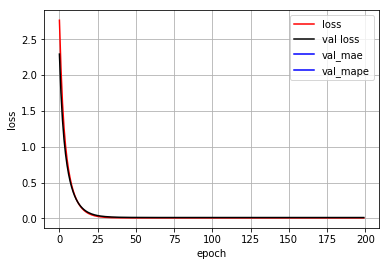

迁移学习LSTM预测


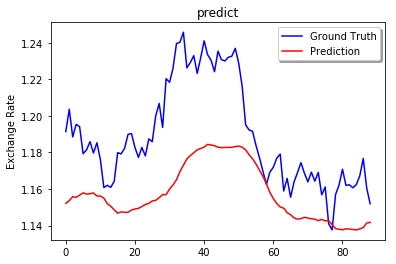

RMSE:0.03580303329191197  ,MAE:0.03141276074098737  ,MAPE:2.6143565037786667 


In [8]:
params = {
          'Timescale':3,
          'lr': 0.001,
          'nb_hidden_cell': [80,80,80,80,80],
          'epochs': 1000,
          'batch_size': 100,
          'TimeLag': 10,
          'TrainTestSplit':0.7,
          
          'TransferEpochs':200,
          'TransferBatch_size':10,
          'frozenlayer':[1,2,3,4,5,6]
        }
'''
1、已经判断是否随着时间跨度的延长，LSTM模型的预测效果会越来越差
2、开始迁移学习实验,2年数据训练基本模型有效，尝试用一年数据

'''
saveFile = r'D:\WORK__wells\GraduateProgram\Model\PreModel_Daily_Data_AUDUSD.h5'
PrepareModel = load_model(saveFile)
# PrepareModel = PrePareLSTM(preTrained_pd, params)
# PrepareModel.save(saveFile)

result_pd = TransferLearning_frozenLayer(data_pd, PrepareModel,params)
# result_pd = PreTest(preTrained_pd, params)

In [9]:
# result_pd.to_csv(r'D:\WORK__wells\GraduateProgram\Result\迁移冻结参数选择2.csv',index=None)

In [10]:
# # plt.plot(result_pd.frozenlayer,result_pd['T-RMSE'], 'r', label='RMSE',linestyle='dashed')
# plt.plot(result_pd.frozenlayer,result_pd['T-MAPE'], 'b', label='MAPE')
# # plt.title('predict')
# plt.xlabel('Number of Frozen Layers')
# plt.ylabel('Score')
# plt.legend(shadow=True)
# plt.show()

In [12]:
result_pd

,frozenlayer,RMSE,MAE,MAPE,T-RMSE,T-MAE,T-MAPE
0,1,NaN,NaN,NaN,0.036654,0.031797,2.643265
1,2,NaN,NaN,NaN,0.039042,0.034350,2.857312
2,3,NaN,NaN,NaN,0.038346,0.033650,2.798822
3,4,NaN,NaN,NaN,0.041485,0.036362,3.022815
4,5,NaN,NaN,NaN,0.042923,0.038143,3.173467
5,6,NaN,NaN,NaN,0.035803,0.031413,2.614357
